In [2]:
import os
HOME = os.getcwd()
print('HOME: ',HOME)

import json
import random
import pandas as pd
import sys
import lxml
import sklearn as sk
import numpy as np

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go



HOME:  /Users/ericsuardi/Desktop/DataMiningProject23-24


In [3]:
STANDARD_FILE = 'standard_small.json'
ACTUAL_FILE = 'actual_small.json'

In [4]:
# load standard and actual data
with open(os.path.join('data',STANDARD_FILE)) as f:
    standard = json.load(f)

with open(os.path.join('data', ACTUAL_FILE)) as f:
    actual = json.load(f)

# load the data into a dataframe
dfStandard = pd.DataFrame(standard)
dfActual = pd.DataFrame(actual)

# print head of the dataframes
print(dfStandard.head())
print(dfActual.head())

# get the unique cities and items of the standard data
cities = []
items = []
longestRoute = 0
shortestRoute = np.inf
for index, s in dfStandard.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    for trip in route:
        cities.append(trip['from']) 
        items.extend(trip['merchandise'].keys())
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
        
    if len(route) < shortestRoute:
        shortestRoute = len(route)

for index, s in dfActual.iterrows():
    #print(s)
    idS = s['id']
    route = s['route']
    for trip in route:
        cities.append(trip['from'])
        items.extend(trip['merchandise'].keys())
    if len(route) > 0:
        cities.append(route[-1]['to'])
        
    if len(route) > longestRoute:
        longestRoute = len(route)
    
    if len(route) < shortestRoute:
        shortestRoute = len(route)

# find the unique cities and items
uniqueCities = sorted(list(set(cities)))
uniqueCities.insert(0, 'NULL')          # add NULL city, for padding vectors with different lengths (trips in routes)
uniqueItems = sorted(list(set(items)))

print("Unique cities: ", uniqueCities)
print("Unique items: ", uniqueItems)

print("Number of cities: ", len(uniqueCities))
print("Number of items: ", len(uniqueItems))

print("Longest route: ", longestRoute)
print("Shortest route: ", shortestRoute)


   id                                              route
0  s0  [{'from': 'Bari', 'to': 'Pesaro', 'merchandise...
1  s1  [{'from': 'Vittoria', 'to': 'Cesena', 'merchan...
2  s2  [{'from': 'Sesto San Giovanni', 'to': 'Foggia'...
3  s3  [{'from': 'Sesto San Giovanni', 'to': 'Rimini'...
4  s4  [{'from': 'Carpi', 'to': 'Fiumicino', 'merchan...
   id driver sroute                                              route
0  a0      J     s0  [{'from': 'Bari', 'to': 'Pesaro', 'merchandise...
1  a1      G     s0  [{'from': 'Bari', 'to': 'Afragola', 'merchandi...
2  a2      D     s0  [{'from': 'Bari', 'to': 'Pesaro', 'merchandise...
3  a3      J     s0  [{'from': 'Bari', 'to': 'Pesaro', 'merchandise...
4  a4      F     s0  [{'from': 'Bari', 'to': 'Pesaro', 'merchandise...
Unique cities:  ['NULL', 'Afragola', 'Agrigento', 'Alessandria', 'Altamura', 'Andria', 'Arezzo', 'Asti', 'Aversa', 'Bari', 'Bolzano-Bozen', 'Brescia', 'Busto Arsizio', 'Caltanissetta', 'Carpi', 'Castellammare di Stabia', 'Catania', 

In [5]:
def extractFeatureVector(df, uniqueCities, uniqueItems, longestRoute):
    # create a feature vector for each row
    featureVectors = []
    for index, row in df.iterrows():
        featureVector = [] 
        idS = row['id']
        route = row['route']
        for trip in route:
            # add the city of departure
            featureVector.append(uniqueCities.index(trip['from']))
            # add the city of arrival
            featureVector.append(uniqueCities.index(trip['to']))
            # add the items
            qntHotMerch = np.zeros(len(uniqueItems))
            for item, n in trip["merchandise"].items():
                qntHotMerch[uniqueItems.index(item)] = n
            #print(qntHotMerch)
            featureVector.extend(np.array(qntHotMerch.tolist()))
        # pad the feature vector with zeros
        while len(featureVector) < longestRoute * (2+len(uniqueItems)):
            featureVector.extend(np.zeros(2+len(uniqueItems)))
        featureVectors.append(featureVector)
    return featureVectors

In [6]:
# extract feature vectors from the data

standardVectors = extractFeatureVector(dfStandard, uniqueCities, uniqueItems, longestRoute)
# DICT VECTORIZER
# listOfDicts = dfStandard.to_dict('records')
# # substitute merchandise dict with a list of items and quantities
# for d in listOfDicts:
#     for i, trip in enumerate(d['route']):
#         values = list(trip['merchandise'].values())
#         d['route'][i]['merchandise'] = list(trip['merchandise'].keys())
#         d['route'][i]['quantities'] = values
# standardVectorsDictVectorizer = sk.feature_extraction.DictVectorizer(sparse=False).fit_transform(listOfDicts)
actualVectors = extractFeatureVector(dfActual, uniqueCities, uniqueItems, longestRoute)
standardIds = dfStandard['id'].tolist()
actualIds = dfActual['sroute'].tolist()
#print("sroute: ", actualIds)

minRouteLength = np.min([len(route) for route in standardVectors] + [len(route) for route in actualVectors])
maxRouteLength = np.max([len(route) for route in standardVectors] + [len(route) for route in actualVectors])
print(standardVectors)
print("Min route length: ", minRouteLength)
print("Max route length: ", maxRouteLength)
        
standardVectors = np.array(standardVectors).astype(float)
actualVectors = np.array(actualVectors).astype(float)

# shape: (numRoutes, maxNumItems+2 (ie: from, to)))
print("standard shape", standardVectors.shape)
print("actual shape", actualVectors.shape)

assert standardVectors.shape[1] == actualVectors.shape[1], "The number of features is not the same between standard and actual data"
assert standardVectors.shape[1] == longestRoute * (2+len(uniqueItems)), "The number of features does not match the expected number, possibly due to a different longest route"

[[9, 35, 20.0, 8.0, 0.0, 0.0, 0.0, 11.0, 23.0, 0.0, 0.0, 0.0, 35, 1, 10.0, 0.0, 1.0, 22.0, 8.0, 0.0, 1.0, 0.0, 11.0, 2.0, 1, 24, 0.0, 10.0, 8.0, 13.0, 1.0, 15.0, 12.0, 0.0, 7.0, 11.0, 24, 38, 0.0, 5.0, 28.0, 28.0, 0.0, 10.0, 22.0, 0.0, 0.0, 0.0, 38, 32, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 32, 49, 0.0, 9.0, 0.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49, 26, 0.0, 0.0, 29.0, 0.0, 0.0, 5.0, 0.0, 0.0, 10.0, 0.0, 26, 12, 7.0, 0.0, 0.0, 8.0, 3.0, 0.0, 0.0, 0.0, 10.0, 0.0, 12, 14, 6.0, 15.0, 15.0, 0.0, 0.0, 11.0, 0.0, 0.0, 15.0, 3.0, 14, 10, 0.0, 13.0, 0.0, 0.0, 4.0, 7.0, 14.0, 0.0, 0.0, 1.0, 10, 41, 5.0, 4.0, 8.0, 29.0, 0.0, 24.0, 24.0, 11.0, 1.0, 6.0, 41, 19, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19, 20, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 0.0, 9.0, 0.0, 0.0, 20, 15, 26.0, 0.0, 0.0, 0.0, 4.0, 11.0, 0.0, 15.0, 11.0, 23.0, 15, 27, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27, 34, 7.0, 0.0, 3.0, 24.0, 6.0, 0.0, 27.0, 29.0, 14.0, 15.0, 34, 8, 0.0, 30.0, 19.0, 20.0, 

In [7]:
# visualize the data in a 3D plot using TSNE, in red the standard data and in blue the actual data
tsne = TSNE(n_components=3, random_state=0, perplexity=5)

# stack the vectors and create a vector of types (0 for standard, 1 for actual)
stackedVectors = np.vstack((standardVectors, actualVectors))
print("stackedVectors shape", stackedVectors.shape)
types = np.hstack((np.zeros(standardVectors.shape[0]), np.ones(actualVectors.shape[0])))

# Fix the IndexError by using the stackedVectors instead of actualVectors for tsne.fit_transform()
vectorsTSNE = tsne.fit_transform(stackedVectors, types)

stackedVectors shape (1010, 588)


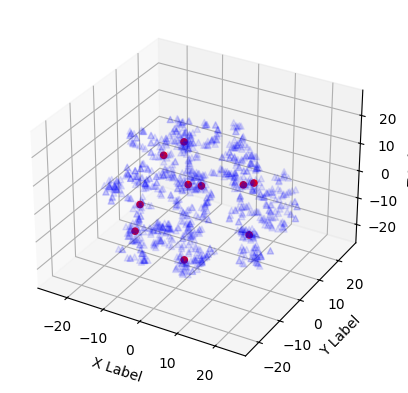

In [8]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(vectorsTSNE[types==0,0], vectorsTSNE[types==0,1], vectorsTSNE[types==0,2], c='r', marker='o', alpha=1)
ax.scatter(vectorsTSNE[types==1,0], vectorsTSNE[types==1,1], vectorsTSNE[types==1,2], c='b', marker='^', alpha=0.1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


# Create a color map that maps each unique label to a color
unique_labels_standard = np.unique(standardIds)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels_standard)))
color_map_standard = dict(zip(unique_labels_standard, colors))

# Use the color map to set the color of the markers
marker_colors_standard = [color_map_standard[label] for label in standardIds]

# Create a trace for each type
trace0 = go.Scatter3d(
    x=vectorsTSNE[types==0,0],
    y=vectorsTSNE[types==0,1],
    z=vectorsTSNE[types==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors_standard,                # set color to an array/list of desired values
        opacity=0.9,
        symbol='diamond'
    )
)


# Create a color map that maps each unique label to a color
unique_labels_actual = np.unique(actualIds)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels_actual)))
color_map_actual = dict(zip(unique_labels_actual, colors))

# Use the color map to set the color of the markers
marker_colors_actual = [color_map_actual[label] for label in actualIds]

trace1 = go.Scatter3d(
    x=vectorsTSNE[types==1,0],
    y=vectorsTSNE[types==1,1],
    z=vectorsTSNE[types==1,2],
    mode='markers',
    marker=dict(
        size=5,
        color=marker_colors_actual,                # set color to an array/list of desired values
        opacity=0.3,
        symbol='circle'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

## Clustering

In [9]:
# K-means clustering

# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
kmeans_model = KMeans(n_clusters=len(standardVectors), random_state=1).fit(actualVectors)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = kmeans_model.labels_

# Sum of distances of samples to their closest cluster center
# inertia = kmeans_model.inertia_
# print("inertia: ", inertia)

# Save the centroids for clusters into a variable.
centroids = kmeans_model.cluster_centers_
print("centroids: ", centroids.shape)

stackedVectorsCentroidsActual = np.vstack((centroids, actualVectors))
typesCentroidAndActual = np.hstack((np.zeros(centroids.shape[0]), np.ones(actualVectors.shape[0])))

# tSNE on the centroids
tsne = TSNE(n_components=3, random_state=0, perplexity=5)
vectorsTSNE_centroids = tsne.fit_transform(stackedVectorsCentroidsActual, typesCentroidAndActual)


# Kind of accuracy
forward_expansion = actualVectors.shape[0] // standardVectors.shape[0]
print("forward_expansion: ", forward_expansion)

accuracy = []
for i in range(standardVectors.shape[0]):
    clusters = []
    for j in range(forward_expansion):
        clusters.append(labels[i*forward_expansion+j])
    
    clusters_count_dict = {i:clusters.count(i) for i in set(clusters)}
    acc = 0
    for c, n in clusters_count_dict.items():
        if clusters.count(c) > 1:
            acc += n / clusters.count(max(clusters, key=clusters.count))
    accuracy.append(acc)
    #accuracy.append(len(set(clusters)))
    print("cluster ", i, " num clusters found: ", len(set(clusters)), " biggest cluster: ", max(clusters, key=clusters.count), " num elements: ", clusters.count(max(clusters, key=clusters.count)))
    
print("mean num predicted clusters per real cluster: ", np.mean(accuracy))

/Users/ericsuardi/Desktop/DataMiningProject23-24/datamining/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



centroids:  (10, 588)
forward_expansion:  100
cluster  0  num clusters found:  2  biggest cluster:  1  num elements:  98
cluster  1  num clusters found:  2  biggest cluster:  9  num elements:  98
cluster  2  num clusters found:  2  biggest cluster:  5  num elements:  97
cluster  3  num clusters found:  3  biggest cluster:  7  num elements:  96
cluster  4  num clusters found:  4  biggest cluster:  6  num elements:  75
cluster  5  num clusters found:  2  biggest cluster:  0  num elements:  98
cluster  6  num clusters found:  2  biggest cluster:  2  num elements:  94
cluster  7  num clusters found:  2  biggest cluster:  3  num elements:  99
cluster  8  num clusters found:  3  biggest cluster:  4  num elements:  95
cluster  9  num clusters found:  2  biggest cluster:  8  num elements:  99
mean num predicted clusters per real cluster:  1.0549337375239403


## Output recommended standard routes

In [16]:
# separate actual vectors using the labels
actualClusters = []
for i in range(len(centroids)):
    actualClusters.append(actualVectors[labels==i])
    
# get the clustroid of each cluster, ie the vector which is closest to all the other vectors in the cluster
clustroids = []
for cluster in actualClusters:
    distances = []
    for vector in cluster:
        distances.append(np.sum([cosine(vector, v) for v in cluster]))
    clustroids.append(cluster[np.argmin(distances)])
    
# sort clustroids by distance from standard vectors so that the first clustroid is the closest to the first standard vector, 
# the second clustroid is the closest to the second standard vector, etc
# Q: shouldn't it compute all the distances between all the clustroids and all the standard vectors?
# 
orderedClustroids = np.zeros_like(clustroids.copy())
order = []
for i, clustroid in enumerate(clustroids):
    distances = []
    for j, standardVector in enumerate(standardVectors):
        distances.append(cosine(clustroid, standardVector))
        
    distances = np.array(distances)
    orderedClustroids[np.argmin(distances)] = clustroid
    order.append(np.argmin(distances))

if len(set(order)) == len(clustroids):
    print("order is correct")
    clustroids = orderedClustroids
print("clustroids: ", clustroids.shape)
print("order: ", order)

# compare if distances between clustroids and standard vectors are smaller than distances between standard vectors and other standard vectors

distancesClustroids = []
distancesStandardVectors = []
for i, clustroid in enumerate(clustroids):
    distancesClustroids.append(np.sum([cosine(clustroid, v) for v in actualClusters[i]]))
    distancesStandardVectors.append(np.sum([cosine(standardVectors[i], v) for v in actualClusters[i]]))
    
print("distancesClustroids: ", distancesClustroids)
print("distancesStandardVectors: ", distancesStandardVectors)

print("\nMean distance from vectors of the same cluster to:")
print("         clustroids: ", np.mean(distancesClustroids))
print("   standard vectors: ", np.mean(distancesStandardVectors))

print("\nStd dev distance from vectors of the same cluster to:")
print("         clustroids: ", np.std(distancesClustroids))
print("   standard vectors: ", np.std(distancesStandardVectors))

print("\n improvement: ", 1 - np.mean(distancesClustroids) / np.mean(distancesStandardVectors), "\n")



    
# convert the vectors back to the original format
clustroidsConvertedJSON = []
for i, clustroid in enumerate(clustroids):
    print("clustroid ", i, " : ", clustroid)
    clustroidConverted = []
    for j in range(0, len(clustroid), 2+len(uniqueItems)):
        # break if the clustroid is padded with zeros
        if clustroid[j] != 0 and clustroid[j+1] != 0:
            clustroidConverted.append({'from': uniqueCities[int(clustroid[j])], 'to': uniqueCities[int(clustroid[j+1])], 'merchandise': {}})
            for k, item in enumerate(uniqueItems):
                if clustroid[j+2+k] > 0:
                    clustroidConverted[-1]['merchandise'][item] = int(clustroid[j+2+k])
    clustroidsConvertedJSON.append(clustroidConverted)
    print("clustroidConverted: ", clustroidConverted)

# save the clustroids to a json file
with open(os.path.join('output','recStandardKMeans.json'), 'w', encoding='utf-8') as outfile:
    json.dump(clustroidsConvertedJSON, outfile, indent=2, ensure_ascii=False)
    

order is correct
clustroids:  (10, 588)
order:  [5, 0, 6, 7, 8, 2, 4, 3, 9, 1]
distancesClustroids:  [48.17590750988896, 76.1298521530642, 45.84624962139444, 59.34653330766685, 53.066093207186775, 56.91386809619745, 49.22207990576092, 60.916435766210206, 42.12175373507192, 53.01843061360729]
distancesStandardVectors:  [48.46296947033109, 76.29438159495933, 46.22788357141085, 59.17542361687441, 52.888352967868, 56.91492594462211, 49.444168918014256, 61.00729134253345, 42.89623038488694, 51.7963372487221]

Mean distance from vectors of the same cluster to:
         clustroids:  54.47572039160491
   standard vectors:  54.51079650602226

Std dev distance from vectors of the same cluster to:
         clustroids:  9.157188435824006
   standard vectors:  9.055495242428416

 improvement:  0.0006434709574180131 

clustroid  0  :  [ 9. 35. 20.  8.  0.  0.  0. 11. 23.  0.  0.  0. 35.  1. 10.  0.  1. 22.
  8.  0.  1.  0. 11.  2.  1. 24.  0. 10.  8. 13.  1. 15. 12.  0.  7. 11.
 24. 38.  0.  5. 28. 

In [11]:
# Create a color map that maps each unique label to a color
unique_labels = np.unique(labels)
print("unique_labels: ", len(unique_labels), "standard vectors len", len(standardVectors))

# Reorder the labels to have colors matching the cluster results, using closest centroid to the standard vectors
unique_labels_reordered = []
can_be_reordered = True
for i in range(len(standardVectors)):
    distances = np.linalg.norm(centroids - standardVectors[i], axis=1)
    closest_centroid = np.argmin(distances)
    if closest_centroid not in unique_labels_reordered:
        unique_labels_reordered.append(closest_centroid)
    else:
        print("closest_centroid already in unique_labels_reordered")
        can_be_reordered = False
        break

if not can_be_reordered:
    unique_labels_reordered = unique_labels

print("unique_labels_reordered: ", len(unique_labels_reordered), unique_labels_reordered)
#unique_labels = unique_labels_reordered
colors_reordered = plt.cm.jet(np.linspace(0, 1, len(unique_labels_reordered)))
color_map_reordered = dict(zip(unique_labels_reordered, colors_reordered))

# Use the color map to set the color of the markers
marker_colors_reordered = [color_map_reordered[label] for label in labels]
print("marker_colors: ", len(marker_colors_reordered))

colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Use the color map to set the color of the markers
marker_colors = [color_map[label] for label in labels]
print("marker_colors: ", len(marker_colors))


# Create a trace for each type (centroids data)
traceStandard = go.Scatter3d(
    x=vectorsTSNE[types==0,0],
    y=vectorsTSNE[types==0,1],
    z=vectorsTSNE[types==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=colors_reordered,                # set color to an array/list of desired values
        opacity=0.9,
        symbol='diamond'
    )
)

# Create a trace for each type (centroids data)
traceActual = go.Scatter3d(
    x=vectorsTSNE[types==1,0],
    y=vectorsTSNE[types==1,1],
    z=vectorsTSNE[types==1,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors_reordered,                # set color to an array/list of desired values
        opacity=0.1,
        symbol='circle'
    )
)

# Plot
data = [traceStandard, traceActual]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

unique_labels:  10 standard vectors len 10
unique_labels_reordered:  10 [1, 9, 5, 7, 6, 0, 2, 3, 4, 8]
marker_colors:  1000
marker_colors:  1000


## t-SNE of centroids of clusters and actual routes

In [12]:




# Create a trace for each type (centroids data)
traceCentroids = go.Scatter3d(
    x=vectorsTSNE_centroids[typesCentroidAndActual==0,0],
    y=vectorsTSNE_centroids[typesCentroidAndActual==0,1],
    z=vectorsTSNE_centroids[typesCentroidAndActual==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=colors,                # set color to an array/list of desired values
        opacity=0.9,
        symbol='diamond'
    )
)

# Create a trace for each type (actual data)
traceActual = go.Scatter3d(
    x=vectorsTSNE_centroids[typesCentroidAndActual==1,0],
    y=vectorsTSNE_centroids[typesCentroidAndActual==1,1],
    z=vectorsTSNE_centroids[typesCentroidAndActual==1,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.2,
        symbol='circle'
    )
)


# Plot
data = [traceCentroids, traceActual]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

In [13]:
# DBSCAN clustering

from sklearn.cluster import DBSCAN
from sklearn import metrics

distances = []
for i in range(len(standardVectors)):
    distancesCluster = []
    for j in range(forward_expansion-1):
        for k in range(j+1, forward_expansion):
            #distance = np.linalg.norm(vectorsTSNE[types==1,:][i*forward_expansion+j] - vectorsTSNE[types==1,:][i*forward_expansion+k])
            #distance = np.linalg.norm(actualVectors[i*forward_expansion+j] - actualVectors[i*forward_expansion+k])
            distance = cosine(actualVectors[i*forward_expansion+j], actualVectors[i*forward_expansion+k])
            distancesCluster.append(distance)
    distances.append(distancesCluster)

print("mean max distance per cluster: ", np.mean(np.max(distances, axis=1)))
print("mean mean distance per cluster: ", np.mean(np.mean(distances, axis=1)))
    

# Compute DBSCAN
# Q: what is eps
# A: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# Q: can i use the mean distance per cluster as eps?
# A: yes, but it is better to use the mean max distance per cluster
# Q: what is min_samples, eli5?


db = DBSCAN(eps=0.32, min_samples=forward_expansion//2, metric=cosine).fit(actualVectors)

labels_DBSCAN = db.labels_
print("num clusters found: ", len(set(labels_DBSCAN)))
print("biggest cluster: ", max(labels_DBSCAN, key=list(labels_DBSCAN).count), " num elements: ", list(labels_DBSCAN).count(max(labels_DBSCAN, key=list(labels_DBSCAN).count)))

# Create a color map that maps each unique label to a color
unique_labels = np.unique(labels_DBSCAN)
print("unique_labels: ", len(unique_labels), "standard vectors len", len(standardVectors))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

# Use the color map to set the color of the markers
marker_colors = [color_map[label] for label in labels_DBSCAN]
print("marker_colors: ", len(marker_colors))


# Create a trace for each type (centroids data)
traceStandard = go.Scatter3d(
    x=vectorsTSNE[types==0,0],
    y=vectorsTSNE[types==0,1],
    z=vectorsTSNE[types==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=colors,                # set color to an array/list of desired values
        opacity=0.9,
        symbol='diamond'
    )
)

# Create a trace for each type (centroids data)
traceActual = go.Scatter3d(
    x=vectorsTSNE[types==1,0],
    y=vectorsTSNE[types==1,1],
    z=vectorsTSNE[types==1,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.1,
        symbol='circle'
    )
)

# Plot
data = [traceStandard, traceActual]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

mean max distance per cluster:  0.5463698522823345
mean mean distance per cluster:  0.3134709120553243
num clusters found:  7
biggest cluster:  0  num elements:  288
unique_labels:  7 standard vectors len 10
marker_colors:  1000


In [14]:
# HDBSCAN clustering
# Compute HDBSCAN
hdb = HDBSCAN(min_samples=1, min_cluster_size=forward_expansion//2, max_cluster_size=forward_expansion, metric=cosine, store_centers="both").fit(actualVectors)

labels_HDBSCAN = hdb.labels_
print("num clusters found: ", len(set(labels_HDBSCAN)))
print("biggest cluster: ", max(labels_HDBSCAN, key=list(labels_HDBSCAN).count), " num elements: ", list(labels_HDBSCAN).count(max(labels_HDBSCAN, key=list(labels_HDBSCAN).count)))

# Create a color map that maps each unique label to a color
unique_labels = np.unique(labels_HDBSCAN)
unique_labels = unique_labels[unique_labels != -1]
print("unique_labels: ", len(unique_labels), unique_labels, "standard vectors len", len(standardVectors))

centroids = hdb.centroids_
medoids = hdb.medoids_

print("centroids: ", centroids.shape)
print("medoids: ", medoids.shape)

# reorder the labels to have colors matching the cluster results, using medoids which are closer to the standard vectors
unique_labels_reordered = []
can_be_reordered = True
for i in range(len(standardVectors)):
    #distances = np.linalg.norm(medoids - standardVectors[i], axis=1)
    distancesCosine = []
    for j in range(len(medoids)):
        distancesCosine.append(cosine(medoids[j], standardVectors[i]))
    closest_medoid = np.argmin(distancesCosine)
    
    if closest_medoid not in unique_labels_reordered:
        unique_labels_reordered.append(closest_medoid)
    else:
        print("closest_medoid already in unique_labels_reordered")
        can_be_reordered = False
        break

if not can_be_reordered:
    unique_labels_reordered = unique_labels

print("unique_labels_reordered: ", len(unique_labels_reordered), unique_labels_reordered)
#unique_labels = unique_labels_reordered


colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels_reordered)))
color_map = dict(zip(unique_labels_reordered, colors))
marker_colors = [color_map[label] if label != -1 else np.array([0,0,0,1]) for label in labels_HDBSCAN]


# Create a trace for each type (centroids data)
traceStandard = go.Scatter3d(
    x=vectorsTSNE[types==0,0],
    y=vectorsTSNE[types==0,1],
    z=vectorsTSNE[types==0,2],
    mode='markers',
    marker=dict(
        size=7,
        color=colors,                # set color to an array/list of desired values
        opacity=1,
        symbol='diamond'
    )
)

# Create a trace for each type (centroids data)
traceActual = go.Scatter3d(
    x=vectorsTSNE[types==1,0],
    y=vectorsTSNE[types==1,1],
    z=vectorsTSNE[types==1,2],
    mode='markers',
    marker=dict(
        size=7,
        color=marker_colors,                # set color to an array/list of desired values
        opacity=0.1,
        symbol='circle'
    )
)

# Plot
data = [traceStandard, traceActual]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


num clusters found:  11
biggest cluster:  6  num elements:  100
unique_labels:  10 [0 1 2 3 4 5 6 7 8 9] standard vectors len 10
centroids:  (10, 588)
medoids:  (10, 588)
unique_labels_reordered:  10 [6, 2, 0, 4, 7, 9, 1, 3, 5, 8]
